# Comparing and evaluating models

In [1]:
# Helper functions for fitting generic sklearn classifier

In [2]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
from PIL import Image

In [25]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
def cv_optimize(clf, parameters, X, y, n_jobs=1, n_folds=5, score_func=None):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, n_jobs=n_jobs, scoring=score_func)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, n_jobs=n_jobs, cv=n_folds)
    gs.fit(X, y)
    print "BEST", gs.best_params_, gs.best_score_, gs.grid_scores_
    best = gs.best_estimator_
    return best
def do_classify(clf, parameters, indf, featurenames, targetname, target1val, mask=None, reuse_split=None, score_func=None, n_folds=5, n_jobs=1):
    subdf=indf[featurenames]
    X=subdf.values
    y=(indf[targetname].values==target1val)*1
    if mask.any() !=None:
        print "using mask"
        Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]
    if reuse_split !=None:
        print "using reuse split"
        Xtrain, Xtest, ytrain, ytest = reuse_split['Xtrain'], reuse_split['Xtest'], reuse_split['ytrain'], reuse_split['ytest']
    if parameters:
        clf = cv_optimize(clf, parameters, Xtrain, ytrain, n_jobs=n_jobs, n_folds=n_folds, score_func=score_func)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print "############# based on standard predict ################"
    print "Accuracy on training data: %0.2f" % (training_accuracy)
    print "Accuracy on test data:     %0.2f" % (test_accuracy)
    print confusion_matrix(ytest, clf.predict(Xtest))
    print "########################################################"
    return clf, Xtrain, ytrain, Xtest, ytest

In [4]:
from matplotlib.colors import ListedColormap
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

def points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=True, colorscale=cmap_light, cdiscrete=cmap_bold, alpha=0.1, psize=10, zfunc=False):
    h = .02
    X=np.concatenate((Xtr, Xte))
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))

    #plt.figure(figsize=(10,6))
    if mesh:
        if zfunc:
            p0 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 0]
            p1 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
            Z=zfunc(p0, p1)
        else:
            Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        plt.pcolormesh(xx, yy, Z, cmap=cmap_light, alpha=alpha, axes=ax)
    ax.scatter(Xtr[:, 0], Xtr[:, 1], c=ytr-1, cmap=cmap_bold, s=psize, alpha=alpha,edgecolor="k")
    # and testing points
    yact=clf.predict(Xte)
    ax.scatter(Xte[:, 0], Xte[:, 1], c=yte-1, cmap=cmap_bold, alpha=alpha, marker="s", s=psize+10)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    return ax,xx,yy

In [5]:
def points_plot_prob(ax, Xtr, Xte, ytr, yte, clf, colorscale=cmap_light, cdiscrete=cmap_bold, ccolor=cm, psize=10, alpha=0.1):
    ax,xx,yy = points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=False, colorscale=colorscale, cdiscrete=cdiscrete, psize=psize, alpha=alpha) 
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=ccolor, alpha=.2, axes=ax)
    cs2 = plt.contour(xx, yy, Z, cmap=ccolor, alpha=.6, axes=ax)
    plt.clabel(cs2, fmt = '%2.1f', colors = 'k', fontsize=14, axes=ax)
    return ax 

## The churn example

This is a dataset from a telecom company, of their customers. Based on various features of these customers and their calling plans, we want to predict if a customer is likely to leave the company. This is expensive for the company, as a lost customer means lost monthly revenue!

In [6]:
dfchurn=pd.read_csv("https://dl.dropboxusercontent.com/u/75194/churn.csv")
dfchurn.head()

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


In [7]:
print dfchurn.shape

(3333, 21)


Lets write some code to feature select and clean our data first, of-course.

In [8]:
# Booleans :)
dfchurn["Int'l Plan"] = dfchurn["Int'l Plan"]=='yes'
dfchurn["VMail Plan"] = dfchurn["VMail Plan"]=='yes'

In [9]:
colswewant_cont=[ u'Account Length', u'VMail Message', u'Day Mins', u'Day Calls', u'Day Charge', u'Eve Mins', u'Eve Calls', u'Eve Charge', u'Night Mins', u'Night Calls', u'Night Charge', u'Intl Mins', u'Intl Calls', u'Intl Charge', u'CustServ Calls']
colswewant_cat=[u"Int'l Plan", u'VMail Plan']

## Asymmetry
First notice that our data set is very highly asymmetric, with positives, or people who churned, only making up 14-15% of the samples.

In [10]:
# Return array WHERE 1 if condition true, else 0
ychurn = np.where(dfchurn['Churn?'] == 'True.',1,0)
100*ychurn.mean()

14.491449144914492

This means that a classifier which predicts that EVERY customer is a negative (does not churn) has an accuracy rate of 85-86%. 

But is accuracy the correct metric?

## Remember the Confusion matrix? We reproduce it here for convenience
- the samples that are +ive and the classifier predicts as +ive are called True Positives (TP)
- the samples that are -ive and the classifier predicts (wrongly) as +ive are called False Positives (FP)
- the samples that are -ive and the classifier predicts as -ive are called True Negatives (TN)
- the samples that are +ive and the classifier predicts as -ive are called False Negatives (FN)

A classifier produces a confusion matrix which looks like this:

![hwimages](./Resources/images/confusionmatrix.png)


IMPORTANT NOTE: In sklearn, to obtain the confusion matrix in the form above, always have the observed `y` first, ie: use as `confusion_matrix(y_true, y_pred)`

Consider two classifiers, A and B, as in the image below. Suppose they were trained on a balanced set. Let A make its mistakes only through false positives: non-churners(n) predicted to churn(Y), while B makes its mistake only through false negatives, churners(p), predicted not to churn(N). Now consider what this looks like on an unbalanced set, where the ps (churners) are much less than the ns (non-churners). It would seem that B makes far fewer misclassifications based on accuracy than A, and would thus be a better classifier.

![m:abmodeldiag](./Resources/images/abmodeldiag.png)

However, is B reaslly the best classifier for us? **False negatives are people who churn, but we predicted them not to churn. These are very costly for us.** So for us. classifier A might be better, even though, on the unbalanced set, it is way less accurate!

## Classifiers should be about the Business End: keeping costs down
#### Establishing Baseline Classifiers via profit or loss
Whenever you are comparing classifiers you should always establish a baseline, one way or the other.  In our churn dataset there are two obvious baselines: assume every customer wont churn, and assume all customers will churn.

The former baseline, will on our dataset, straight away give you a 85.5% accuracy. If you are planning on using accuracy, any classifier you write ought to beat this. The other baseline, from an accuracy perspective is less interesting: it would only have a 14.5% correct rate.

But as we have seen, on such asymmetric data sets, accuracy is just not a good metric. So what should we use?

**A metric ought to hew to the business function that the classifier is intended for**.

In our case, we want to minimize the cost/maximize the profit for the telecom.

But to do this we need to understand the business situation. To do this, we write a **utility**, or, equivalently, **cost** matrix associated with the 4 scenarios that the confusion matrix talks about. 

![cost matrix](./Resources/images/costmatrix.png)

Remember that +ives or 1s are churners, and -ives or 0s are the ones that dont churn. 

Lets assume we make an offer with an administrative cost of \$3 and an offer cost of \$100, an incentive for the customer to stay with us. If a customer leaves us, we lose the customer lifetime value, which is some kind of measure of the lost profit from that customer. Lets assume this is the average number of months a customer stays with the telecom times the net revenue from the customer per month. We'll assume 3 years and \$30/month margin per user lost, for roughly a $1000 loss.

In [11]:
admin_cost=3
offer_cost=100
clv=1000 # Customer's lifetime value to the business

- TN = people we predicted not to churn who wont churn. We associate no cost with this as they continue being our customers
- FP = people we predict to churn. Who wont. Lets associate a `admin_cost+offer_cost` cost per customer with this as we will spend some money on getting them not to churn, but we will lose this money.
- FN = people we predict wont churn. And we send them nothing. But they will. This is the big loss, the `clv`
- TP = people who we predict will churn. And they will. These are the people we can do something with. So we make them an offer. Say a fraction **f** accept it i.e, continue to stay with us. 

**Our cost is:**

`f * offer_cost + (1-f)*(clv+admin_cost)`

This model can definitely be made more complex.

Lets assume a conversion fraction of 0.5

In [12]:
conv = 0.5
tnc = 0.
fpc = admin_cost+offer_cost
fnc = clv
tpc = conv*offer_cost + (1. - conv)*(clv+admin_cost)

In [13]:
# So, cost matrix:
cost=np.array([[tnc,fpc],[fnc, tpc]])
print cost

[[    0.    103. ]
 [ 1000.    551.5]]


We can compute the average cost(profit) per person using the following formula, which calculates the "expected value" of the per-customer loss/cost(profit):

\begin{eqnarray}
Cost &=& c(1P,1A) \times p(1P,1A) + c(1P,0A) \times p(1P,0A) + c(0P,1A) \times p(0P,1A) + c(0P,0A) \times p(0P,0A) \\
&=& \frac{TP \times c(1P,1A) + FP \times c(1P,0A) + FN \times c(0P,1A) + TN \times c(0P,0A)}{N}
\end{eqnarray}

where N is the total size of the test set, 1P is predictions for class 1, or positives, 0A is actual values of the negative class in the test set. The first formula above just weighs the cost of a combination of observed and predicted with the out-of-sample probability of the combination occurring. The probabilities are "estimated" by the corresponding confusion matrix on the test set.

The cost can thus be found by multiplying the cost matrix by the confusion matrix elementwise, and dividing by the sum of the elements in the confusion matrix, or the test set size.

We implement this process of finding the average cost per person in the `average_cost` function below:

In [14]:
def average_cost(y, ypred, cost):
    c=confusion_matrix(y,ypred)
    score=np.sum(c*cost)/np.sum(c)
    return score

#### No customer churns and we send nothing
We havent made any calculations yet! Lets fix that omission and create our training and test sets.

In [15]:
churntrain, churntest = train_test_split(xrange(dfchurn.shape[0]), train_size=0.6)
churnmask=np.ones(dfchurn.shape[0], dtype='int')
churnmask[churntrain]=1
churnmask[churntest]=0
churnmask = (churnmask==1)
churnmask

array([False, False, False, ..., False, False,  True], dtype=bool)

In [16]:
testchurners=dfchurn['Churn?'][~churnmask].values=='True.'

In [17]:
# Predict all y = 0 i.e. No customers churn

In [18]:
testsize = dfchurn[~churnmask].shape[0]
ypred_dste = np.zeros(testsize, dtype="int")
print confusion_matrix(testchurners, ypred_dste)

[[1135    0]
 [ 199    0]]


In [19]:
dsteval=average_cost(testchurners, ypred_dste, cost)
dsteval

149.17541229385307

Thus, not doing anything costs us 150 per customer i.e. simply predicting no one churns - which is extremely likely given the asymmetry of data set

#### All customers churn, we send everyone

In [22]:
ypred_ste = np.ones(testsize, dtype="int")
print confusion_matrix(testchurners, ypred_ste)

[[   0 1135]
 [   0  199]]


In [23]:
steval=average_cost(testchurners, ypred_ste, cost)
steval

169.90517241379311

Make offers to everyone costs us even more, not surprisingly. The first one is the one to beat!

## Naive Bayes Classifier
So lets try a classifier. Here we try one known as Gaussian Naive Bayes. We'll just use the default parameters, since the actual details are not of importance to us.

In [26]:
from sklearn.naive_bayes import GaussianNB
clfgnb = GaussianNB()
clfgnb, Xtrain, ytrain, Xtest, ytest=do_classify(clfgnb, None, dfchurn, colswewant_cont+colswewant_cat, 'Churn?', "True.", mask=churnmask)

using mask
############# based on standard predict ################
Accuracy on training data: 0.87
Accuracy on test data:     0.86
[[1045   90]
 [  91  108]]
########################################################


In [27]:
confusion_matrix(ytest, clfgnb.predict(Xtest))

array([[1045,   90],
       [  91,  108]])

In [28]:
average_cost(ytest, clfgnb.predict(Xtest), cost)

119.81409295352324

Ok! We did better! But is this the true value of our cost? To answer this question, we need to ask a question: what exactly is `clf.predict` doing?

There is a caveat for SVM's though: we cannot repredict 1's and 0's directly for  `clfsvm`, as the SVM is whats called a "discriminative" classifier: it directly gives us a decision function, with no probabilistic explanation and no probabilities. (I lie, an SVM can be retrofitted with probabilities: see http://scikit-learn.org/stable/modules/svm.html#scores-probabilities, but these are expensive and not always well calibrated (calibration of probabilities will be covered later in our class)).

What do we do? The SVM does give us a measure of how far we are from the "margin" though, and this is an ordered set of distances, just as the probabilities in a statistical classifier are. This ordering on the distance is just like an ordering on the probabilities: a sample far on the positive side from the line is an almost very definite 1, just like a sample with a 0.99 probability of being a 1 is an almost very definite 1.

For both these reasons we turn to ROC curves.

## Changing the Prediction threshold, and the ROC Curve
Our dataset is a very lopsided data set with 86% of samples being negative. We now know that in such a case, accuracy is not a very good measure of a classifier.

We have also noticed that, as is often the case in situations in which one class dominates the other, the costs of one kind of misclassification: false negatives are differently expensive than false positives. We saw above that FN are more costly in our case than FP. 


In the case of such asymmetric costs, the `sklearn` API function `predict` is useless, as it assumes a threshold probability of having a +ive sample to be 0.5; that is, if a sample has a greater than 0.5 chance of being a 1, assume it is so. Clearly, when FN are more expensive than FP, you want to lower this threshold: you are ok with falsely classifying -ive examples as +ive. We play with this below by chosing a threshold `t` in the function `repredict` which chooses a different threshold than 0.5 to make a classification.

You can think about this very starkly from the perspective of the cancer doctor. Do you really want to be setting a threshold of 0.5 probability to predict if a patient has cancer or not? The false negative problem: ie the chance you predict someone dosent have cancer who has cancer is much higher for such a threshold. You could kill someone by telling them not to get a biopsy. Why not play it safe and assume a much lower threshold: for eg, if the probability of 1(cancer) is greater than 0.05, we'll call it a 1.

One caveat: we cannot repredict for the linear SVM model `clfsvm`, as the SVM is whats called a "discriminative" classifier: it directly gives us a decision function, with no probabilistic explanation and no probabilities.

In [29]:
def repredict(est,t, xtest):
    probs=est.predict_proba(xtest)
    p0 = probs[:,0]
    p1 = probs[:,1]
    ypred = (p1 >= t)*1
    return ypred

In [30]:
average_cost(ytest, repredict(clfgnb, 0.3, Xtest), cost)

111.52623688155921

(array([ 874.,  128.,   70.,   30.,   34.,   29.,   20.,   10.,   22.,  117.]),
 array([  9.52316167e-05,   1.00084106e-01,   2.00072980e-01,
          3.00061855e-01,   4.00050729e-01,   5.00039603e-01,
          6.00028477e-01,   7.00017352e-01,   8.00006226e-01,
          8.99995100e-01,   9.99983975e-01]),
 <a list of 10 Patch objects>)

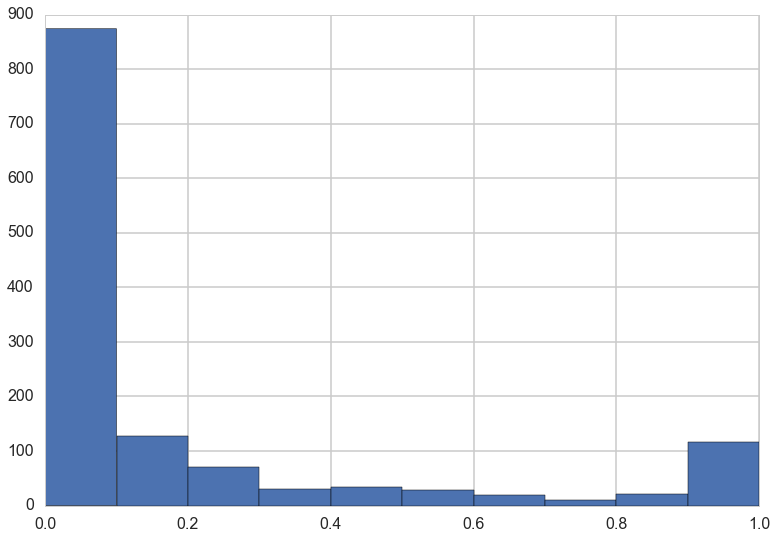

In [31]:
plt.hist(clfgnb.predict_proba(Xtest)[:,1])

Aha! At a 0.3 threshold we save more money!

We see that in this situation, where we have asymmetric costs, we do need to change the threshold at which we make our positive and negative predictions. We need to change the threshold so that we much dislike false negatives (same in the cancer case). Thus we must accept many more false positives by setting such a low threshold.

For otherwise, we let too many people slip through our hands who would have stayed with our telecom company given an incentive. But how do we pick this threshold?

### The ROC Curve
ROC curves are actually a set of classifiers, in which we move the threshold for classifying a sample as positive from 0 to 1. (In the standard scenario, where we use classifier accuracy, this threshold is implicitly set at 0.5).

We talked more about how to create a ROC curve in the accompanying lab to this one, so here we shall just repeat the ROC curve making code from there.

In [32]:
from sklearn.metrics import roc_curve, auc

In [33]:
def make_roc(name, clf, ytest, xtest, ax=None, labe=5, proba=True, skip=0):
    initial=False
    if not ax:
        ax=plt.gca()
        initial=True
    if proba:
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict_proba(xtest)[:,1])
    else:
        fpr, tpr, thresholds=roc_curve(ytest, clf.decision_function(xtest))
    roc_auc = auc(fpr, tpr)
    if skip:
        l=fpr.shape[0]
        ax.plot(fpr[0:l:skip], tpr[0:l:skip], '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    else:
        ax.plot(fpr, tpr, '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    label_kwargs = {}
    label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.3', alpha=0.2,
    )
    for k in xrange(0, fpr.shape[0],labe):
        threshold = str(np.round(thresholds[k], 2))
        ax.annotate(threshold, (fpr[k], tpr[k]), **label_kwargs)
    if initial:
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC')
    ax.legend(loc="lower right")
    return ax

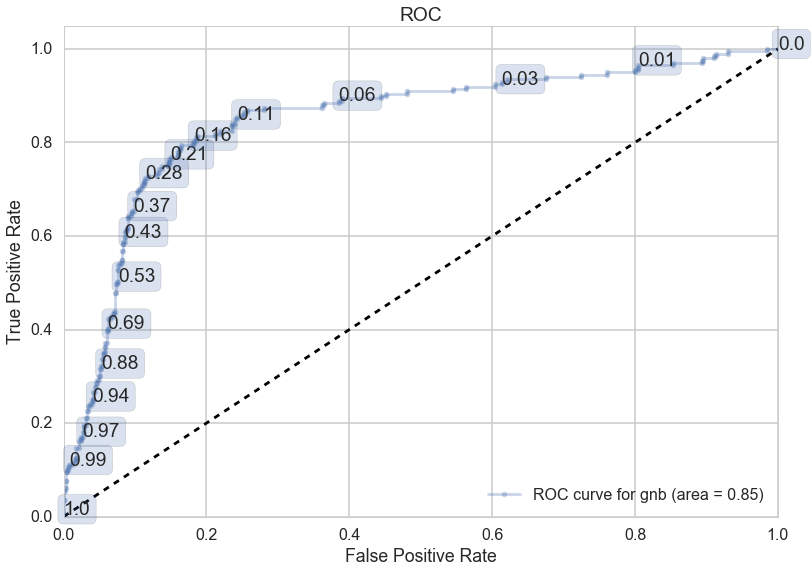

In [42]:
make_roc("gnb",clfgnb, ytest, Xtest, None, labe=15)

OK. Now that we have a ROC curve that shows us different thresholds, we need to figure how to pick the appropriate threshold from the ROC curve. But first, let us try another classifier.